## Learn to count problem


The objectives of this notebook is to explore a dataset, and try to define a machine learning model that is able to determine the number of people that appear in a given image, using convolutional neuronal networks. 

In [1]:
# some imports
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"


# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras

assert tf.__version__ >= "2.0"


# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
plt.rc('font', size=12) 
plt.rc('figure', figsize = (12, 5))

# Settings for the visualizations
#import seaborn as sns
#sns.set_style("whitegrid")
#sns.set_context("notebook", font_scale=1, rc={"lines.linewidth": 2,'font.family': [u'times']})

import pandas as pd
pd.set_option('display.max_rows', 25)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', 50)

from skimage import io

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

from functools import partial
from keras.models import Sequential
from keras.layers import BatchNormalization, Convolution2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array

### Dataset loading

First we need to load the datasets

In [2]:
train_txt_folder = '/kaggle/input/mlub2021-session8/train.txt'
train_folder = '/kaggle/input/mlub2021-session8/train/train/train'
test_folder = '/kaggle/input/mlub2021-session8/test/test/test'

In [3]:
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array

with open(train_txt_folder) as f:
    lines = f.readlines()

Load the training data

In [4]:
X_train_full = list()
y_train_full = list()
for line in lines:
    image_path, label = line.split(' ')
    image = load_img('/kaggle/input/mlub2021-session8/train/train/'+image_path[1:], color_mode = "grayscale")
    data = img_to_array(image) / 255.0
    X_train_full.append(data)
    y_train_full.append(float(label))



Load the test data

In [5]:
import os
X_test = list()
folder = test_folder
folder_list = os.listdir(folder)
folder_list.sort()
for filename in folder_list:
    image = load_img(os.path.join(folder,filename),  color_mode = "grayscale")
    data = img_to_array(image)/ 255.0
    X_test.append(data)



In [6]:
X_train_full = np.array(X_train_full)
y_train_full = np.array(y_train_full)
X_test = np.array(X_test)

Now we see how the images of our dataset look like.

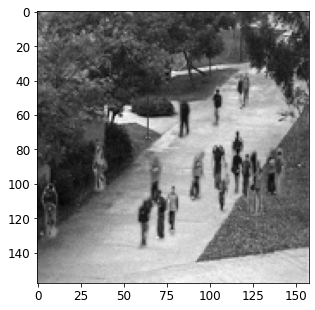

In [7]:
plt.imshow(X_train_full[0], cmap = 'gray')
plt.show()

In [8]:
print("Each image is shaped: ", X_train_full[0].shape)
print("That means that we have ", X_train_full[0].shape[0] * X_train_full[0].shape[1], " pixels per image")

Each image is shaped:  (158, 158, 1)
That means that we have  24964  pixels per image


                  0
count  15000.000000
mean      14.377067
std        8.655134
min        0.000000
25%        7.000000
50%       14.000000
75%       22.000000
max       29.000000


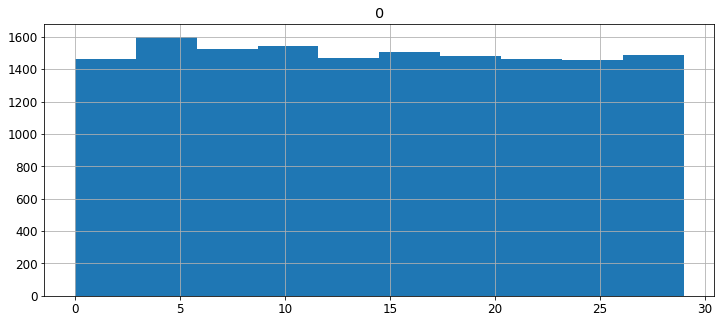

In [9]:
#Observe data and its distribution 
df = pd.DataFrame(y_train_full)
df.hist()
print(df.describe())

Due to the Neuronal Networks nature, I think that Normalizing the labels could be benefitial.

In [10]:
#labels_max = y_train_full.max()
#y_train_full = y_train_full.astype(float)
#y_train_full /= labels_max 

Indeed it has an influence, but negative influence! I tested and saw that not normalizing the labels improved the score. I think that it is because of the way the RMS score is computed, as if we rescale the labels, we are changing in some way the loss function, and this afects negatively to the network. 

I decided to leave both cells above to show the progress done and some thought progress.

Then we split into train and validation the train set.test_folder

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, test_size=0.25, random_state=42)


In [12]:
del X_train_full
del y_train_full

### The model

Now we will try to define a CNN model to have a baseline model to begin with, and then try to make improvements to it

In [13]:
from functools import partial
from keras.models import Sequential
from keras.layers import BatchNormalization, Convolution2D, MaxPooling2D, Flatten, Dense, Dropout

In [14]:

base_model=Sequential()
base_model.add(BatchNormalization(input_shape = (158,158,1)))
base_model.add(Convolution2D(filters = 32, kernel_size = 3, activation ='relu',padding='same', input_shape = (158, 158, 1))) 
base_model.add(MaxPooling2D(pool_size=2))
base_model.add(Convolution2D(filters=6,kernel_size=4,padding='same',activation='relu'))
base_model.add(MaxPooling2D(pool_size=2))
base_model.add(Convolution2D(filters=128,kernel_size=3,padding='same',activation='relu'))
base_model.add(MaxPooling2D(pool_size=2))
base_model.add(Convolution2D(filters=128,kernel_size=2,padding='same',activation='relu'))
base_model.add(MaxPooling2D(pool_size=2))
base_model.add(Flatten()) 
base_model.add(Dense(units=128,activation = 'relu'))
base_model.add(Dense(units = 64, activation = 'relu'))
base_model.add(Dense(units = 32, activation = 'relu'))
base_model.add(Dense(units = 16, activation = 'relu'))
"""
The output is a neuron with linear activation.
We can imagine that images with similar labels, will have similar outputs,
this is no longer a classification problem, is a regression one.
"""
base_model.add(Dense(units = 1, activation = 'linear'))

checkpoint_cb = keras.callbacks.ModelCheckpoint("keras_baseline", save_best_only=True)

# define loss function, optimizer and metrics
base_model.compile(loss="mean_squared_error",
              optimizer="adam")

base_model.summary()



2022-01-12 20:37:33.689416: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-12 20:37:33.781622: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-12 20:37:33.782349: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-12 20:37:33.783652: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 158, 158, 1)       4         
_________________________________________________________________
conv2d (Conv2D)              (None, 158, 158, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 79, 79, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 79, 79, 6)         3078      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 39, 39, 6)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 39, 39, 128)       7040      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 19, 19, 128)       0

In [15]:
# train the model and validate using val data
history = base_model.fit(X_train, y_train, epochs=20, batch_size = 32,
                    validation_data=(X_valid, y_valid),
                        callbacks=[checkpoint_cb])


2022-01-12 20:37:36.442627: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1123380000 exceeds 10% of free system memory.
2022-01-12 20:37:37.578805: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1123380000 exceeds 10% of free system memory.
2022-01-12 20:37:38.397662: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20


2022-01-12 20:37:39.669966: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


352/352 [==============================] - 14s 20ms/step - loss: 16.7382 - val_loss: 19.7735


2022-01-12 20:37:52.844808: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


Epoch 2/20
352/352 [==============================] - 6s 18ms/step - loss: 3.6170 - val_loss: 2.8770
Epoch 3/20
352/352 [==============================] - 6s 18ms/step - loss: 3.0314 - val_loss: 2.5580
Epoch 4/20
352/352 [==============================] - 6s 18ms/step - loss: 2.8626 - val_loss: 3.3424
Epoch 5/20
352/352 [==============================] - 6s 18ms/step - loss: 2.5254 - val_loss: 1.9646
Epoch 6/20
352/352 [==============================] - 6s 18ms/step - loss: 2.1618 - val_loss: 3.2063
Epoch 7/20
352/352 [==============================] - 6s 18ms/step - loss: 2.3652 - val_loss: 1.8098
Epoch 8/20
352/352 [==============================] - 6s 18ms/step - loss: 2.0134 - val_loss: 1.9842
Epoch 9/20
352/352 [==============================] - 6s 18ms/step - loss: 1.7983 - val_loss: 2.3703
Epoch 10/20
352/352 [==============================] - 6s 18ms/step - loss: 1.7354 - val_loss: 1.6492
Epoch 11/20
352/352 [==============================] - 7s 18ms/step - loss: 1.6423 - val_l

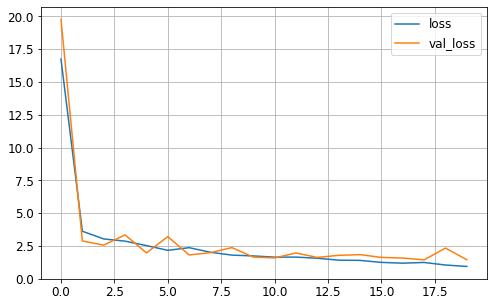

118/118 - 1s - loss: 1.4445


1.444547176361084

In [16]:
# plot training curves
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.show()

# evaluate the model using test data
base_model.evaluate(X_valid, y_valid,verbose=2)


In [17]:
del base_model

We see that with this baseline model, the CNN quickly overfits, later we should implement some techniques to avoid that.

In [18]:
best_base_model = keras.models.load_model("keras_baseline") # rollback to best model
mse_test = best_base_model.evaluate(X_valid, y_valid, verbose = 2)


118/118 - 1s - loss: 1.4368


In [19]:
del best_base_model


## Model Improvements 

### Using pretrained models

Before, we used a CNN with some manually defined parameters. Defining these parameters, as the number of layers, convolution sizes, layers shapes... is a really hard task, as the only way to truely see a model performance is to train it and evaluate it. However, this is a very slow process. For this reason, using a pretrained model, allows us to have a Convolution network with a predefined shape, and pretrained with parameters that could be used for image recognition tasks.

##### Resnet50

Our images are grayscaled, and the resnet50 network is trained with 3 channels, so we need to do some modifications to our dataset to use the resnet50 network.

In [20]:
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array

with open(train_txt_folder) as f:
    lines = f.readlines()

In [21]:
# We do not load the test set yet beacuse does not fit in the kaggle memory if we have previously loaded the other one

""""
X_train_full = list()
y_train_full = list()
for line in lines:
    image_path, label = line.split(' ')
    image = load_img('/kaggle/input/mlub2021-session8/train/train/'+image_path[1:]) # Color mode is set to 3 channels now
    data = img_to_array(image) / 255.0
    X_train_full.append(data)
    y_train_full.append(float(label))
"""

'"\nX_train_full = list()\ny_train_full = list()\nfor line in lines:\n    image_path, label = line.split(\' \')\n    image = load_img(\'/kaggle/input/mlub2021-session8/train/train/\'+image_path[1:]) # Color mode is set to 3 channels now\n    data = img_to_array(image) / 255.0\n    X_train_full.append(data)\n    y_train_full.append(float(label))\n'

In [22]:
# We do not load the test set yet beacuse does not fit in memory
"""
import os
X_test = list()
folder = test_folder
folder_list = os.listdir(folder)
folder_list.sort()
for filename in folder_list:
    image = load_img(os.path.join(folder,filename)) # Color mode is set to 3 channels now
    data = img_to_array(image)/ 255.0
    X_test.append(data)
"""

'\nimport os\nX_test = list()\nfolder = test_folder\nfolder_list = os.listdir(folder)\nfolder_list.sort()\nfor filename in folder_list:\n    image = load_img(os.path.join(folder,filename)) # Color mode is set to 3 channels now\n    data = img_to_array(image)/ 255.0\n    X_test.append(data)\n'

In [23]:
"""
X_train_full = np.array(X_train_full)
y_train_full = np.array(y_train_full)
X_test = np.array(X_test)
"""

'\nX_train_full = np.array(X_train_full)\ny_train_full = np.array(y_train_full)\nX_test = np.array(X_test)\n'

In [24]:
"""
print("Each image is shaped: ", X_train_full[0].shape)
print("That means that we have ", X_train_full[0].shape[0] * X_train_full[0].shape[1] * X_train_full[0].shape[2], " pixels per image")
"""

'\nprint("Each image is shaped: ", X_train_full[0].shape)\nprint("That means that we have ", X_train_full[0].shape[0] * X_train_full[0].shape[1] * X_train_full[0].shape[2], " pixels per image")\n'

In [25]:
#labels_max = y_train_full.max()
#y_train_full = y_train_full.astype(float)
#y_train_full /= labels_max 

In [26]:
from sklearn.model_selection import train_test_split
"""
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, test_size=0.25, random_state=42)
"""

'\nX_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, test_size=0.25, random_state=42)\n'

In [27]:
from tensorflow.keras.applications import resnet50

resnet_model = resnet50.ResNet50(
    # Load pretrained model
    weights='imagenet',
    # Set input shape
    input_shape=(158,158,3),
    # We need to modify the fully connected layers in order to setup for a regression problem
    include_top=False,
    pooling='avg'  # A global average pooling layer will be added after the last convolutional block.

        
)

94781440/94765736 [==============================] - 0s 0us/step


In [28]:
resnet_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 158, 158, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 164, 164, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 79, 79, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 79, 79, 64)   256         conv1_conv[0][0]                 
___________________________________________________________________________________________

### Adding dropout layers

We need to add the fully connected layers and we can also include dropout layers to avoid overfit.

In [29]:
fully_c1 = Dense(128, activation='relu')(resnet_model.output)
drop = Dropout(0.001)(fully_c1)
fully_c2 = Dense(32, activation='relu')(drop)
final = Dense(1, activation='linear')(fully_c2)

model_50 = keras.models.Model(inputs=resnet_model.input, outputs=final)

In [30]:
del resnet_model

In [31]:
model_50.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 158, 158, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 164, 164, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 79, 79, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 79, 79, 64)   256         conv1_conv[0][0]                 
______________________________________________________________________________________________

Now we have to train the model

In [32]:
optimizer = keras.optimizers.Adam(
    # Adjusting the learning rate could be one parameter to play with
    learning_rate=0.001,
)

model_50.compile(
    optimizer=optimizer, 
    loss="mean_squared_error",
    metrics=['mean_absolute_error', 'mean_squared_error']
)

checkpoint_cb = keras.callbacks.ModelCheckpoint("keras_res50", save_best_only=True)


I am not training the network in this notebook, as it takes too long, and if I do so I cannot save the kaggle version.

In [33]:
# train the model and validate using val data
"""
history = model_50.fit(X_train, y_train, epochs=100, batch_size = 32,
                    validation_data=(X_valid, y_valid),
                        callbacks=[checkpoint_cb])
"""

'\nhistory = model_50.fit(X_train, y_train, epochs=100, batch_size = 32,\n                    validation_data=(X_valid, y_valid),\n                        callbacks=[checkpoint_cb])\n'

In [34]:
del model_50


Even thought that in the long term this network should be the one that gets higher scores, for now we will stick to the one created previously, as the resnet has more than 24 million parameters. That means that training this network is really expensive computationally, and it takes a lot to get good results.



## Data augmentation

We can make our datasets bigger by adding modified images with the training ones. We can use the ImageDataGenerator class utility from keras to do that.

Notes about data augmentation. I think that, for this particular dataset, we should no modify the images shape in any way, as all the images have the same background. If we modify the shape, we are making it harder for the network to recognise when an area, which used the be a background, now is filled by an object to recognise. To do data augmentation, we will use other parameters as image brigthness.

In [35]:
from keras.preprocessing.image import ImageDataGenerator

data_generator = ImageDataGenerator(
    # We can change the brightness by a 0.8 to 1.2 factor
    brightness_range=[0.8,1.2],
    #width_shift_range=5,
    #height_shift_range=5,
    # We want the images to be 0-1 scaled
    rescale = 1./255.0
)
train_iterator = data_generator.flow(X_train, y_train, batch_size=1)
valid_iterator = data_generator.flow(X_valid, y_valid, batch_size=1)

##### Examples of images composed with the Image generator

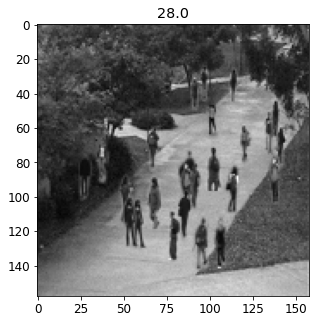

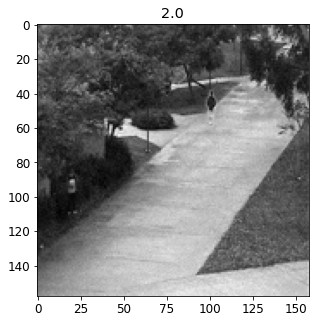

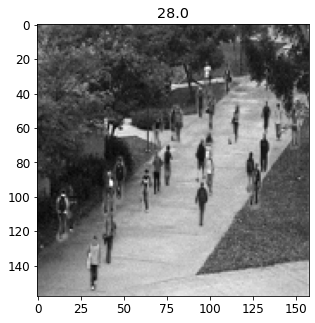

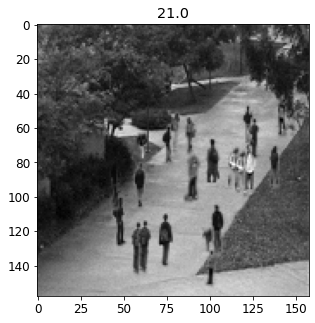

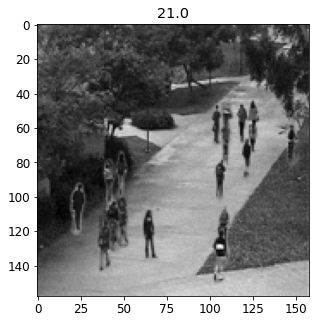

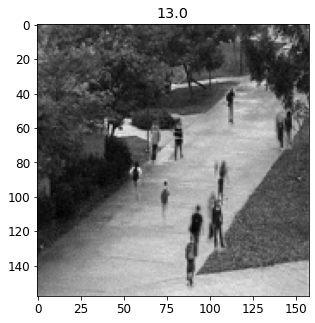

In [36]:
for i in range(6):
    batch = train_iterator.next()
    image = batch[0][0]
    plt.imshow(image, cmap = 'gray')
    plt.title(batch[1][0])
    plt.show()

In [37]:
del X_train
del X_valid
del y_valid
del y_train
del X_test

### Extra ideas

#### Remove innecessary image parts

As we have examined the dataset, we know for sure that the objects to recognise will not appear in some areas, as the trees. For that reason, we can mask those areas, as we do not want the neuronal network to waste time training for those areas, which do not add any information.

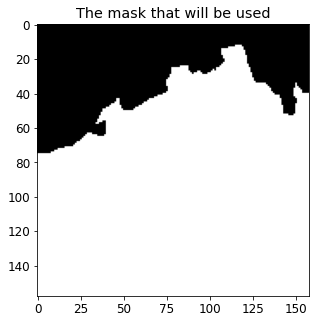

In [38]:
mask = load_img('/kaggle/input/mask-mlubsession8/mask.png',  color_mode = "grayscale")
sample_image = img_to_array(load_img('/kaggle/input/mlub2021-session8/train/train/train/train_composite000000000.png',  color_mode = "grayscale"))/255.0
floating_mask = img_to_array(mask)/ 255.0
boolean_mask = floating_mask[:,:,0] > 0.
plt.imshow(floating_mask, cmap = 'gray')
plt.title('The mask that will be used')
plt.show()

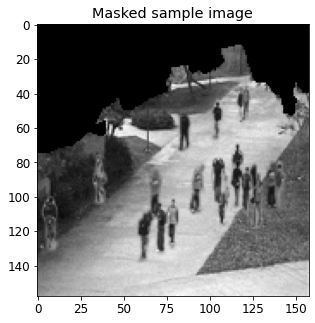

In [39]:
sample_image_masked = sample_image * floating_mask
plt.imshow(sample_image_masked,cmap = 'gray')
plt.title('Masked sample image')
plt.show()

#### Help the network with the gradient

As we are trying to recognise objects, it may be helpfull to instead of using the original images, apply the gradient of the image before processing. The gradient of an image shows the edges of objects, and this may help the network to detect easier the objects. In this case we will use the sobel filter to try to detect edges in all directions.

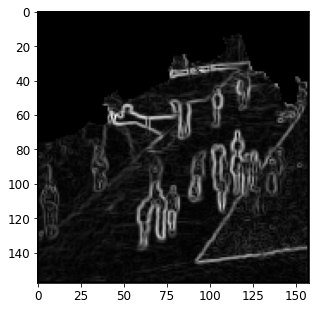

In [40]:
from skimage import filters
from skimage import util
from skimage.color import rgb2gray

image_sample = sample_image[:,:,0].copy()
# The filter parameter defines which neighbours should be used in the gradient computation
_filter = np.array([[0, 1, 0], [1, 1, 1], [0, 1, 0]])
boolean_mask = floating_mask[:,:,0] > 0.
image_gradient = filters.sobel(image_sample.astype(float), mask = boolean_mask)

# Normalize the gradient
image_gradient = image_gradient.astype(float)
image_gradient /= 255.0

plt.imshow(image_gradient, cmap = 'gray')
plt.show()

In [41]:
def sobel_data(data):
    boolean_mask = floating_mask[:,:,0] > 0.
    ret_img = np.zeros((data.shape[0],data.shape[1],1))
    ret_img[:,:,0] = filters.sobel(data[:,:,0].copy().astype(float), mask = boolean_mask)
    return ret_img

#### Substract the background

Now, we can load an image labeled with 0 objects, and substract the gradient, to left only the objects

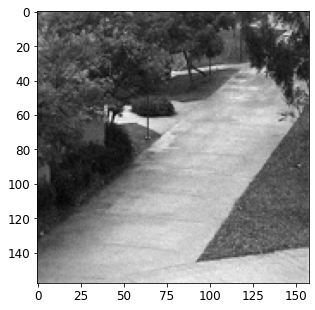

In [42]:
background = load_img('/kaggle/input/mlub2021-session8/train/train/train/train_composite000000017.png',  color_mode = "grayscale")
background = img_to_array(background)/ 255.0

plt.imshow(background,cmap = 'gray')
plt.show()

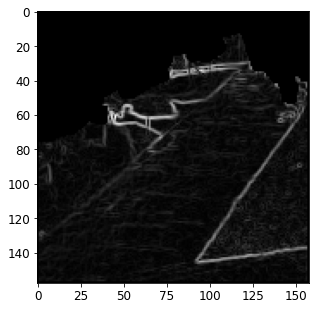

In [43]:
sobel_background = filters.sobel(background[:,:,0].astype(float), mask=boolean_mask)
plt.imshow(sobel_background,cmap='gray')
plt.show()

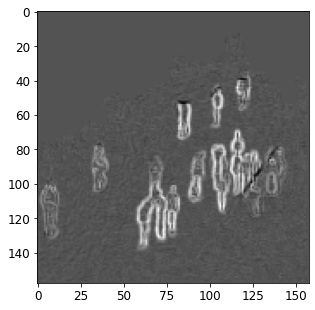

In [44]:
plt.imshow(sobel_data(sample_image)[:,:,0] - sobel_background, cmap = 'gray')
plt.show()

In [45]:
def preprocess(data):
    ret_img = np.zeros((data.shape[0],data.shape[1],1))
    ret_img[:,:,0] = sobel_data(data)[:,:,0] - sobel_background
    return np.abs(ret_img)

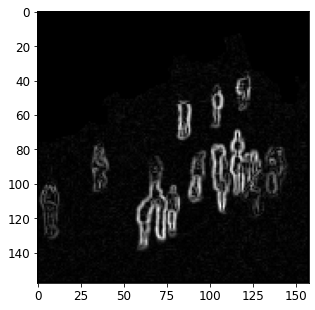

In [46]:
plt.imshow(preprocess(sample_image), cmap = 'gray')
plt.show()

##### About the gradient results

Indeed I have not obtained any improvement applying the gradient. I think it could be a good idea, but in this case, applying the gradient we are losing some features, and this is not benefitial for the network. Ideally, the network should be trained in a way that by itself is able to apply all this preprocessing with the convolution, without any preprocess, but I thought that this may give it extra initial help. 

In [47]:
def preprocess(data):
    ret_img = np.zeros((data.shape[0],data.shape[1],1))
    ret_img[:,:,0] = data[:,:,0] * floating_mask[:,:,0]
    
    return ret_img

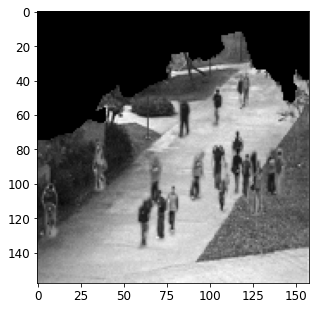

In [48]:
plt.imshow(preprocess(sample_image), cmap = 'gray')
plt.show()

#### Reloading the dataset

Now we reload the dataset, but masking the images.

In [49]:
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array

with open(train_txt_folder) as f:
    lines = f.readlines()

In [50]:
X_train_full = list()
y_train_full = list()
for line in lines:
    image_path, label = line.split(' ')
    image = load_img('/kaggle/input/mlub2021-session8/train/train/'+image_path[1:], color_mode = "grayscale")
    data = img_to_array(image) / 255.0
    data *= floating_mask
    data = preprocess(data)
    X_train_full.append(data)
    y_train_full.append(float(label))

In [51]:
import os
X_test = list()
folder = test_folder
folder_list = os.listdir(folder)
folder_list.sort()
for filename in folder_list:
    image = load_img(os.path.join(folder,filename),  color_mode = "grayscale")
    data = img_to_array(image)/ 255.0
    data *= floating_mask
    data = preprocess(data)
    X_test.append(data)



In [52]:
X_train_full = np.array(X_train_full)
y_train_full = np.array(y_train_full)
X_test = np.array(X_test)

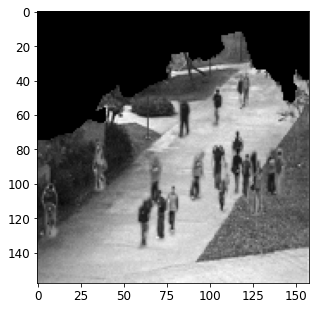

In [53]:
plt.imshow(X_train_full[0], cmap = 'gray')
plt.show()

In [54]:
#labels_max = y_train_full.max()
#y_train_full = y_train_full.astype(float)
#y_train_full /= labels_max 

In [55]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, test_size=0.25, random_state=42)
del X_train_full
del y_train_full

In [56]:
data_generator = ImageDataGenerator(
    # We can change the brightness by a 0.8 to 1.2 factor
    #brightness_range=[0.9,1.1],
    #width_shift_range=5,
    #height_shift_range=5,
    # We want the images to be 0-1 scaled
    rescale = 1./255.0
)
train_iterator = data_generator.flow(X_train, y_train, batch_size=1)


#### Testing the model with the preprocessed images

Now we will define the final model, and try to play with some parameters to get higher scores.

In [57]:

model=Sequential()
model.add(BatchNormalization(input_shape = (158,158,1)))
model.add(Convolution2D(filters = 32, kernel_size = 3,padding='same',activation ='relu', input_shape = (158, 158, 1))) 
model.add(MaxPooling2D(pool_size=2))
model.add(Convolution2D(filters=6,kernel_size=4,padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Convolution2D(filters=128,kernel_size=3,padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Convolution2D(filters=128,kernel_size=2,padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Flatten()) 
model.add(Dense(units=128,activation = 'relu'))
model.add(Dropout(0.001))
model.add(Dense(units = 64, activation = 'relu'))
model.add(Dense(units = 32, activation = 'relu'))
model.add(Dense(units = 16, activation = 'relu'))

"""
The output is a neuron with linear activation.
We can imagine that images with similar labels, will have similar outputs,
this is no longer a classification problem, is a regression one.
"""
model.add(Dense(units = 1, activation = 'linear'))

checkpoint_cb = keras.callbacks.ModelCheckpoint("keras_model", save_best_only=True)


optimizer = keras.optimizers.Adam(
    # Adjusting the learning rate could be one parameter to play with
    learning_rate=0.001,
)
# define loss function, optimizer and metrics
model.compile(loss="mean_squared_error",
              optimizer=optimizer)

model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_1 (Batch (None, 158, 158, 1)       4         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 158, 158, 32)      320       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 79, 79, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 79, 79, 6)         3078      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 39, 39, 6)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 39, 39, 128)       7040      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 19, 19, 128)      

In [58]:
# train the model and validate using val data
BS = 32
EPOCHS = 100
history = model.fit(
    #generator = train_iterator,
    X_train, y_train,
    validation_data= (X_valid, y_valid),
    steps_per_epoch=len(X_train) // BS,
    epochs=EPOCHS,
    callbacks=[checkpoint_cb])

2022-01-12 20:42:08.683751: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1123380000 exceeds 10% of free system memory.
2022-01-12 20:42:09.901160: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1123380000 exceeds 10% of free system memory.


Epoch 1/100
351/351 [==============================] - 8s 22ms/step - loss: 20.1032 - val_loss: 17.6157
Epoch 2/100
351/351 [==============================] - 7s 19ms/step - loss: 4.1487 - val_loss: 3.0132
Epoch 3/100
351/351 [==============================] - 7s 19ms/step - loss: 3.1003 - val_loss: 3.1912
Epoch 4/100
351/351 [==============================] - 7s 20ms/step - loss: 2.7964 - val_loss: 3.4885
Epoch 5/100
351/351 [==============================] - 7s 19ms/step - loss: 2.3649 - val_loss: 1.9974
Epoch 6/100
351/351 [==============================] - 7s 20ms/step - loss: 2.3088 - val_loss: 2.4401
Epoch 7/100
351/351 [==============================] - 7s 19ms/step - loss: 2.1067 - val_loss: 1.7593
Epoch 8/100
351/351 [==============================] - 7s 19ms/step - loss: 1.9317 - val_loss: 1.6835
Epoch 9/100
351/351 [==============================] - 7s 19ms/step - loss: 1.7540 - val_loss: 1.7683
Epoch 10/100
351/351 [==============================] - 7s 20ms/step - loss: 1.5

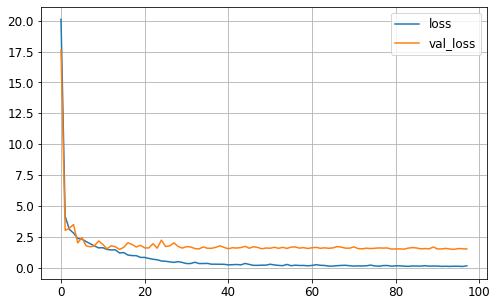

118/118 - 1s - loss: 1.5089


1.5089483261108398

In [59]:
# plot training curves
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.show()

# evaluate the model using test data
model.evaluate(X_valid, y_valid,verbose=2)

In [60]:
del model 

In [61]:
best_model = keras.models.load_model("keras_model") # rollback to best model
mse_test = best_model.evaluate(X_valid, y_valid, verbose = 2)

118/118 - 1s - loss: 1.4686


### Testing our model

In order to test the model we will generate a kaggle submission and see the score. We should note that we should generate submissions based on our validation methods, and avoid using the kaggle competition to avoid overfitting the testing dataset.

In [62]:
y_pred = best_model.predict(X_test)
#y_pred *= labels_max

In [63]:
df_output = pd.DataFrame(y_pred)
df_output = df_output.reset_index()
df_output.columns = ['index','prediction']

df_output.to_csv('kaggle_model.csv',index=False)

## Delivery Details

In this project, I have included the parts in order to get up to **6 points**:

- **Complex convolutional networks**: Resnet50 network, added dropout layers and played with the CNN shape and parameters to get higher scores.

- **Data Augmentation**: Used the ImageDataGenerator class, tried different image transformations as brightness, pixels shifting... And checked if the predictions improved.

- **"Smart" Ideas**: Used some image processing techniques to preprocess the images, as subtracting the background, masking some image parts, applying the gradient...


Even thought I have included all of these parts of the notebook, some of them did not improve the score, and were not included in the submission. However, if they did not work, I have tried to think why and put a little explanation about why I think that is happening. Even if they are making the score worse, it thought it could be interesting to explore them, and I believe some of them could actually improve the predictions if they were explored deeper.